In [150]:
import pyspark
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [151]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import mean
from pyspark.sql.functions import to_date
from pyspark.sql.functions import avg, when, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline



In [152]:
spark = SparkSession.builder.appName("T20CricketAnalysis").getOrCreate()

In [153]:
data = spark.read.csv('/Users/sameekshabs/Downloads/T20I Cricket Ball-by-Ball Data (2003 - 2023).csv', header=True, inferSchema=True)

In [154]:
data.show(5) 

+---+--------+---------+---------------+-----------+------------+-------+----+----+---------+-----------+----------+-----------+----------+--------------+-------------+----------+------+------+----------+------------+---------------+------------+-----------+---------------+------------+-------------------+-----------------+----------------------+------------------+-----------------------+---------------+----------------------+--------------------+----------+
|_c0|Match ID|     Date|          Venue|  Bat First|  Bat Second|Innings|Over|Ball|   Batter|Non Striker|    Bowler|Batter Runs|Extra Runs|Runs From Ball|Ball Rebowled|Extra Type|Wicket|Method|Player Out|Innings Runs|Innings Wickets|Target Score|Runs to Get|Balls Remaining|      Winner|Chased Successfully|Total Batter Runs|Total Non Striker Runs|Batter Balls Faced|Non Striker Balls Faced|Player Out Runs|Player Out Balls Faced|Bowler Runs Conceded|Valid Ball|
+---+--------+---------+---------------+-----------+------------+-------+-

23/10/22 19:27:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

In [155]:
data.describe().show()

23/10/22 19:28:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

+-------+------------------+------------------+---------+--------------------+-----------+-----------+-------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+------------------+--------------------+-------------------+-------------------+-------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------+-------------------+------------------+----------------------+------------------+-----------------------+------------------+----------------------+--------------------+-------------------+
|summary|               _c0|          Match ID|     Date|               Venue|  Bat First| Bat Second|            Innings|             Over|              Ball|           Batter|      Non Striker|           Bowler|       Batter Runs|         Extra Runs|    Runs From Ball|       Ball Rebowled|         Extra Type|             Wicket| Method|       P

In [156]:
X = ["Innings Runs", "Batter Runs", "Batter Balls Faced"]
data.select(X).describe().show()


+-------+-----------------+------------------+------------------+
|summary|     Innings Runs|       Batter Runs|Batter Balls Faced|
+-------+-----------------+------------------+------------------+
|  count|           425119|            425119|            425119|
|   mean|68.76311338707515|1.1395021158781424|12.486560233722793|
| stddev|46.23442079045019|1.5460201550897545|11.475981319620676|
|    min|                0|                 0|                 0|
|    max|              278|                 7|                76|
+-------+-----------------+------------------+------------------+



In [157]:
numerical_cols = ["Innings Runs", "Batter Runs", "Batter Balls Faced", "Bowler Runs Conceded"]
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
assembled_data = assembler.transform(data).select("features")

# Compute Pearson correlation matrix
pearson_corr = Correlation.corr(assembled_data, "features").head()
corr_matrix = pearson_corr[0].toArray()

# Print the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
[[1.         0.14001819 0.32023612 0.14000433]
 [0.14001819 1.         0.15664141 0.98353732]
 [0.32023612 0.15664141 1.         0.15626011]
 [0.14000433 0.98353732 0.15626011 1.        ]]


In [158]:
cleaned_data = data.dropna(subset=["Target Score"])

In [159]:
# Fill missing values with mean for numerical columns
mean_value = cleaned_data.select(mean(cleaned_data["Target Score"])).collect()[0][0]
cleaned_data = cleaned_data.fillna(mean_value, subset=["Target Score"])

In [160]:
# Convert date column to timestamp with specific date format 'M/d/yyyy'
from pyspark.sql.functions import to_date
cleaned_data = cleaned_data.withColumn("Date", to_date("Date", "M/d/yyyy"))
X
# Calculate strike rate for batsmen: (Batter Runs / Batter Balls Faced) * 100
cleaned_data = cleaned_data.withColumn("StrikeRate", (cleaned_data["Batter Runs"] / cleaned_data["Batter Balls Faced"]) * 100)

# Handle other necessary data transformations as per your business requirements
# For example, you can create a new binary column indicating if a player got out or not
from pyspark.sql.functions import when
cleaned_data = cleaned_data.withColumn("IsOut", when(cleaned_data["Player Out"] == "not out", 0).otherwise(1))

# Check the transformed data
cleaned_data.show(5)

+---+--------+----------+---------------+-----------+------------+-------+----+----+---------+-----------+----------+-----------+----------+--------------+-------------+----------+------+------+----------+------------+---------------+------------+-----------+---------------+------------+-------------------+-----------------+----------------------+------------------+-----------------------+---------------+----------------------+--------------------+----------+----------+-----+
|_c0|Match ID|      Date|          Venue|  Bat First|  Bat Second|Innings|Over|Ball|   Batter|Non Striker|    Bowler|Batter Runs|Extra Runs|Runs From Ball|Ball Rebowled|Extra Type|Wicket|Method|Player Out|Innings Runs|Innings Wickets|Target Score|Runs to Get|Balls Remaining|      Winner|Chased Successfully|Total Batter Runs|Total Non Striker Runs|Batter Balls Faced|Non Striker Balls Faced|Player Out Runs|Player Out Balls Faced|Bowler Runs Conceded|Valid Ball|StrikeRate|IsOut|
+---+--------+----------+-------------

23/10/22 19:28:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

In [161]:
categorical_columns = ["Venue", "Batter", "Non Striker", "Bowler", "Extra Type", "Method", "Winner"]

# Check if indexed columns already exist
existing_columns = cleaned_data.columns
indexers = []
for column in categorical_columns:
    indexed_col_name = column + "_index"
    if indexed_col_name not in existing_columns:
        indexer = StringIndexer(inputCol=column, outputCol=indexed_col_name).fit(cleaned_data)
        indexers.append(indexer)


In [164]:
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features",
    handleInvalid="skip"
)


In [166]:
# Assuming you have the indexers already set up from previous steps
for indexer in indexers:
    cleaned_data = indexer.transform(cleaned_data)


In [167]:
assembled_data = assembler.transform(cleaned_data)


In [168]:
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=1234)


In [169]:
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep")
    for column in categorical_columns
]


In [170]:
lr = LinearRegression(featuresCol='features', labelCol='Innings Runs', maxIter=10, regParam=0.3, elasticNetParam=0.8)


In [171]:
# Assuming you have two features: 'Batter Runs' and 'Batter Balls Faced'
feature_columns = ['Batter Runs', 'Batter Balls Faced']

# Step 1: Transform features
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = vector_assembler.transform(data)

# Step 2: Split data into training and test sets
train_data, test_data = assembled_data.randomSplit([0.7, 0.3])

# Step 3: Train the model
lr_model = lr.fit(train_data)

# Step 4: Make predictions on test data
predictions = lr_model.transform(test_data)

# Step 5: Evaluate the model
evaluator = RegressionEvaluator(labelCol="Innings Runs", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


23/10/22 19:30:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

Root Mean Squared Error (RMSE) on test data = 43.610651011010425


In [172]:
print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)


Coefficients: [2.5852944648883938,1.2170935757021122]
Intercept: 50.62393154454576


In [173]:
# R-squared
r2_evaluator = RegressionEvaluator(labelCol="Innings Runs", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

# Mean Absolute Error
mae_evaluator = RegressionEvaluator(labelCol="Innings Runs", predictionCol="prediction", metricName="mae")
mae = mae_evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")


23/10/22 19:31:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

R-squared on test data = 0.10965458611466727


23/10/22 19:31:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

Mean Absolute Error (MAE) on test data = 35.74220697193719


In [174]:
residuals = predictions.select("Innings Runs", "prediction").withColumn("residual", predictions["Innings Runs"] - predictions["prediction"])
residuals.show()


23/10/22 19:31:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

+------------+------------------+-------------------+
|Innings Runs|        prediction|           residual|
+------------+------------------+-------------------+
|           6| 63.39929655550356| -57.39929655550356|
|          10| 64.61639013120568| -54.61639013120568|
|          11|60.511787463646826|-49.511787463646826|
|          11| 55.49230584735421| -44.49230584735421|
|          16| 62.94597461505106| -46.94597461505106|
|          28| 62.94597461505106| -34.94597461505106|
|          32| 71.91895158541834| -39.91895158541834|
|          32| 64.01196087726899| -32.01196087726899|
|          33| 69.03144249356161| -36.03144249356161|
|          49| 86.82628912081204|-37.826289120812035|
|          57| 73.13604516112046|-16.136045161120464|
|          61| 74.35313873682257|-13.353138736822572|
|          62| 74.96580305858801|-12.965803058588008|
|          68| 81.95791481800359|-13.957914818003587|
|          74|  83.1750083937057| -9.175008393705696|
|          78| 80.4386066153

In [180]:
train_data, test_data = assembled_data.randomSplit([0.7, 0.3], seed=1234)
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)


23/10/22 19:36:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

In [181]:
import pandas as pd

pandas_df = predictions.select("Batter Runs", "Batter Balls Faced", "Innings Runs", "prediction").toPandas()


23/10/22 19:36:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

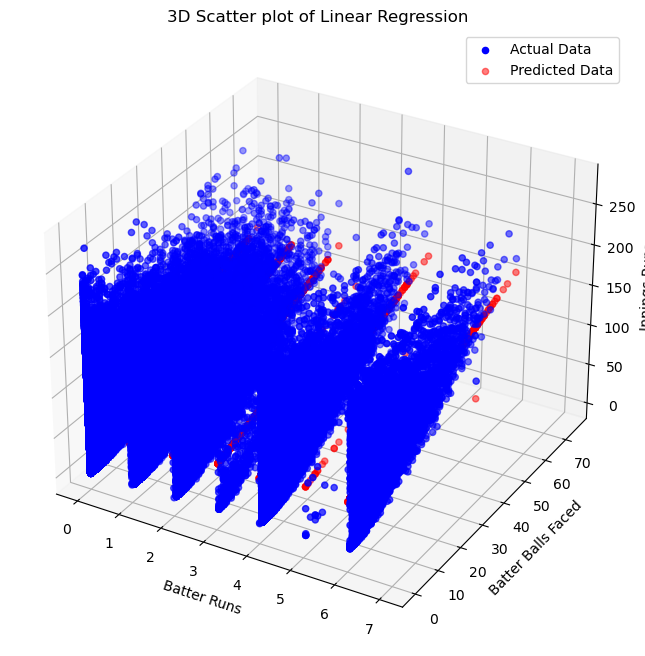

In [182]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of original data
ax.scatter(pandas_df["Batter Runs"], pandas_df["Batter Balls Faced"], pandas_df["Innings Runs"], color='b', label='Actual Data')

# Plotting the predicted values
ax.scatter(pandas_df["Batter Runs"], pandas_df["Batter Balls Faced"], pandas_df["prediction"], color='r', marker='o', alpha=0.5, label='Predicted Data')

ax.set_xlabel('Batter Runs')
ax.set_ylabel('Batter Balls Faced')
ax.set_zlabel('Innings Runs')
ax.set_title('3D Scatter plot of Linear Regression')
ax.legend()

plt.show()


In [184]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Innings Runs')
gbt_model = gbt.fit(train_data)


23/10/22 19:40:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

In [185]:
actual = predictions.select("Innings Runs").toPandas()
predicted = predictions.select("prediction").toPandas()


23/10/22 19:41:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler Runs Conceded, Valid Ball
 Schema: _c0, Match ID, Date, Venue, Bat First, Bat Second, Innings, Over, Ball, Batter, Non Striker, Bowler, Batter Runs, Extra Runs, Runs From Ball, Ball Rebowled, Extra Type, Wicket, Method, Player Out, Innings Runs, Innings Wickets, Target Score, Runs to Get, Balls Remaining, Winner, Chased Successfully, Total Batter Runs, Total Non Striker Runs, Batter Balls Faced, Non Striker Balls Faced, Player Out Runs, Player Out Balls Faced, Bowler R

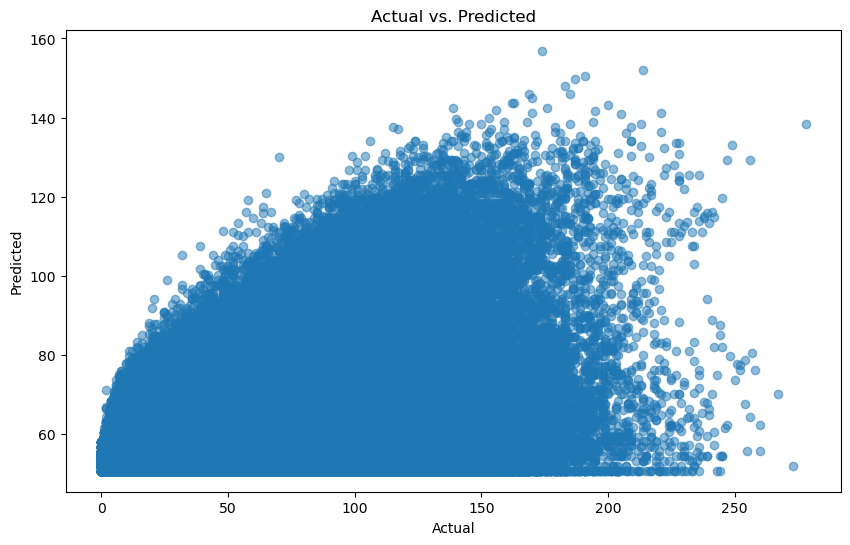

In [186]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(actual, predicted, alpha=0.5)
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


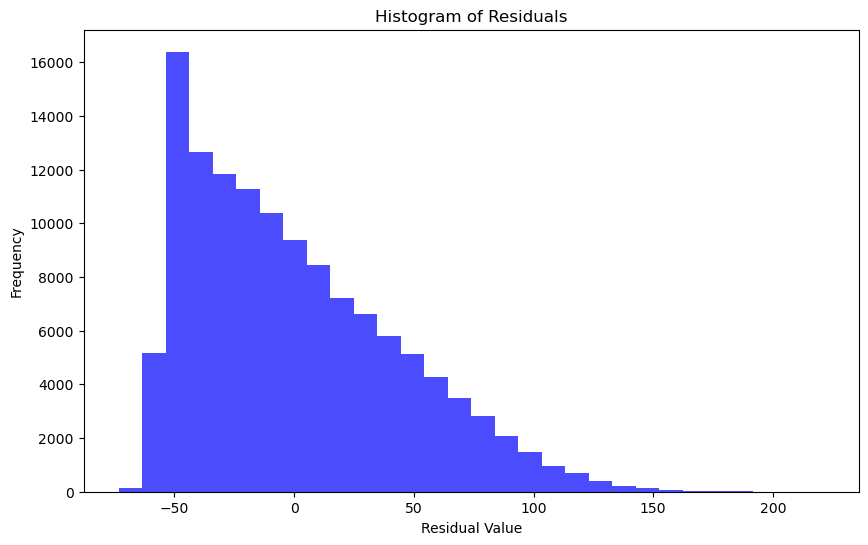

In [187]:
residuals = actual["Innings Runs"] - predicted["prediction"]

plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()
